In [6]:
import numpy as np
# import odl
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
# # from ClassFiles import util as ut 
# from ClassFiles.Framework import AdversarialRegulariser
# from ClassFiles.networks import ConvNetClassifier
# from ClassFiles.forward_models import CT, CT_undersampled
# from ClassFiles.data_pips import LUNA
# import torch
import os
import json
# import pydicom as dc
from tqdm import tqdm
from data import LUNA, Dataset, fMRIData
from torch.utils.data import DataLoader
import torch
from skimage.transform import resize as imresize
import odl
from utils import OperatorModule
from torch.autograd import Variable
from operators import CT, MRI
from utils import fft2c, embed_tensor_complex, ifft2c
import random

In [16]:
with open('/store/CCIMI/sl767/LUNA/Training_Data/individual_npy.json', 'r') as fp:
    data = json.load(fp)

In [17]:
len(data)

76138

In [18]:
data[0]

'/store/CCIMI/sl767/LUNA/Training_Data/LIDC-IDRI-0263/1.3.6.1.4.1.14519.5.2.1.6279.6001.270353012134249392641585941598/1.3.6.1.4.1.14519.5.2.1.6279.6001.183844250620142399426112799260/000001.npy'

In [19]:
random.shuffle(data)

In [20]:
data[0]

'/store/CCIMI/sl767/LUNA/Training_Data/LIDC-IDRI-0311/1.3.6.1.4.1.14519.5.2.1.6279.6001.256415982022395230813284649190/1.3.6.1.4.1.14519.5.2.1.6279.6001.177252583002664900748714851615/000025.npy'

In [22]:
with open('/store/CCIMI/sl767/LUNA/Training_Data/individual_npy.json', 'w') as fp:
    json.dump(data, fp)

In [21]:
len(data)

76138

In [4]:
sample = next(iter(dataset))

In [5]:
sample = next(iter(dataset))
m1 = operator.forward_torch(sample)
m2 = operator.add_noise(m1, noise_level=2e-3)

(-0.5, 99.5, 364.5, -0.5)

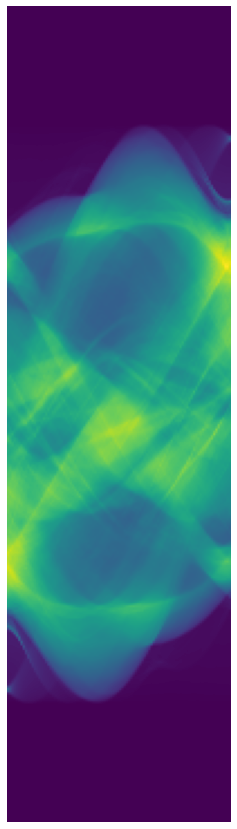

In [13]:
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(m1[1,0,...]))
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

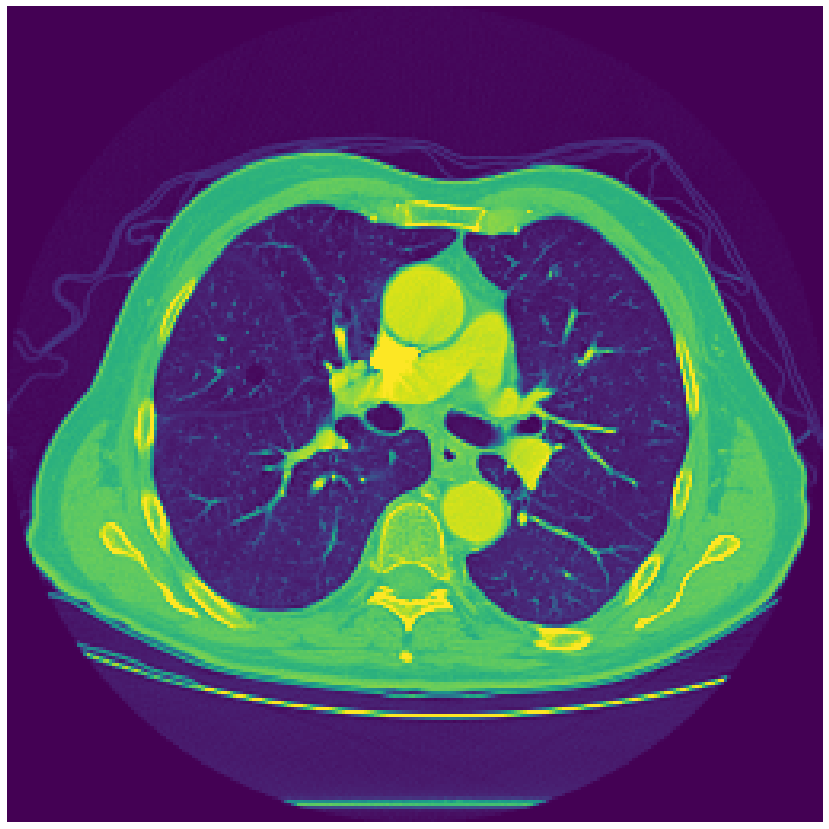

In [10]:
plt.figure(figsize=(15,15))
plt.imshow(sample[1,0,...])
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

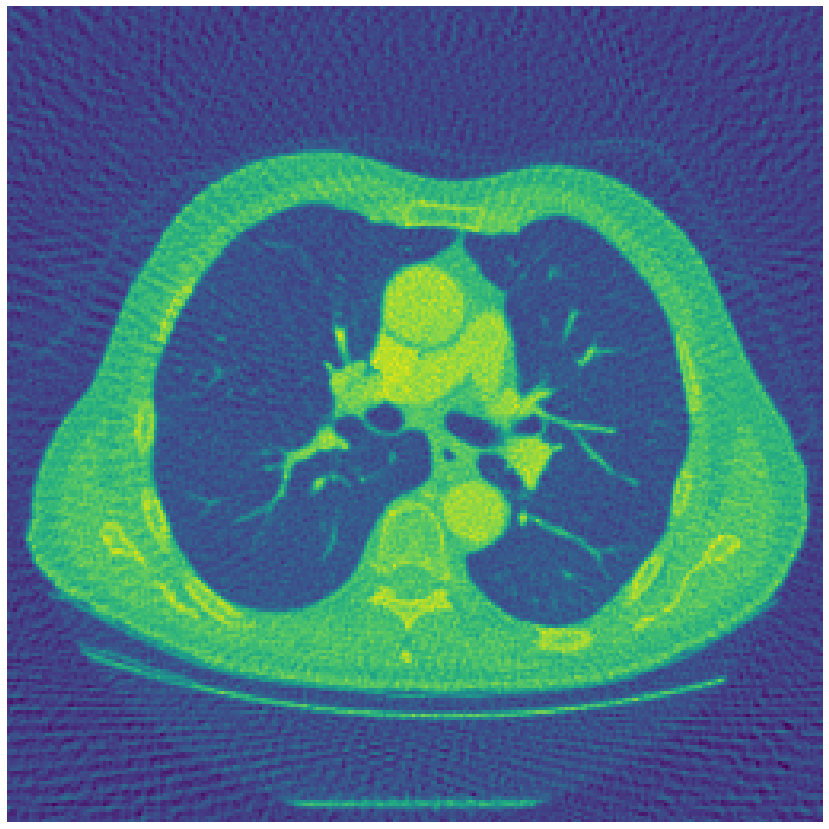

In [9]:
plt.figure(figsize=(15,15))
plt.imshow(operator.inverse_torch(m2)[1,0,...])
plt.axis('off')

Number of training samples found 1304394
Sampling pattern loaded


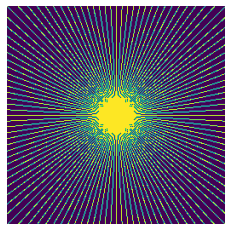

MRI Operator
Resolution 256
Subsampling level: 0.24310302734375

In [17]:
dataset = DataLoader(fMRIData(), batch_size=10)
operator = MRI(n_directions=60)
operator

In [18]:
sample = next(iter(dataset)).cuda()
m1 = operator.forward_torch(sample)
m2 = operator.add_noise(m1, noise_level=1e-3)

(-0.5, 255.5, 255.5, -0.5)

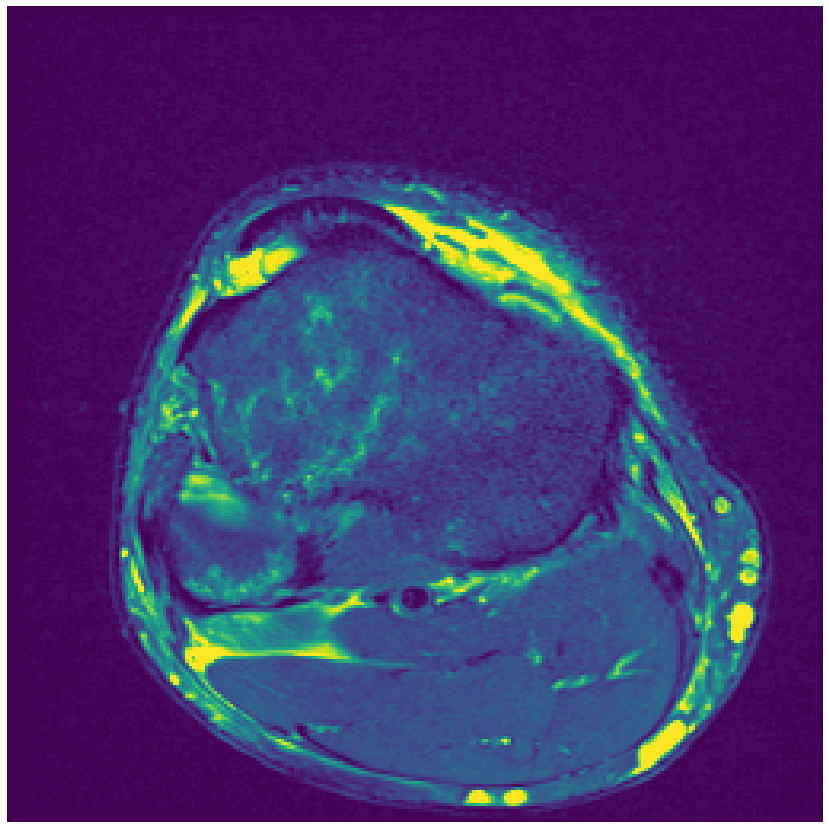

In [19]:
plt.figure(figsize=(15,15))
plt.imshow(sample.cpu()[3,0,...])
plt.axis('off')

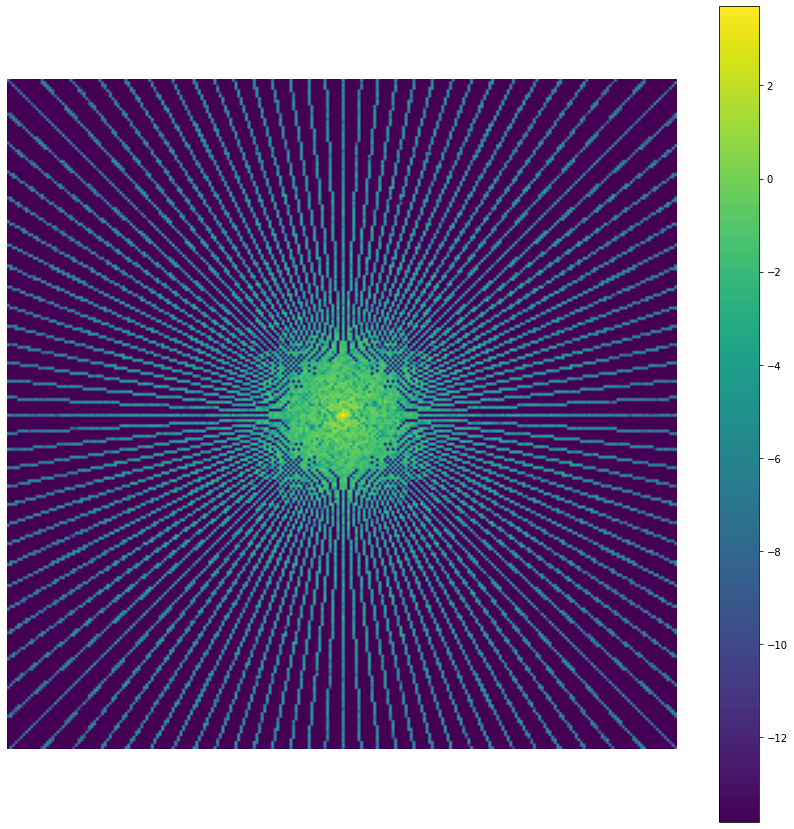

In [20]:
plt.figure(figsize=(15,15))
plt.imshow(np.log(np.abs(m1.cpu()[3,0,...,0])+1e-6))
plt.axis('off')
plt.colorbar()

(-0.5, 255.5, 255.5, -0.5)

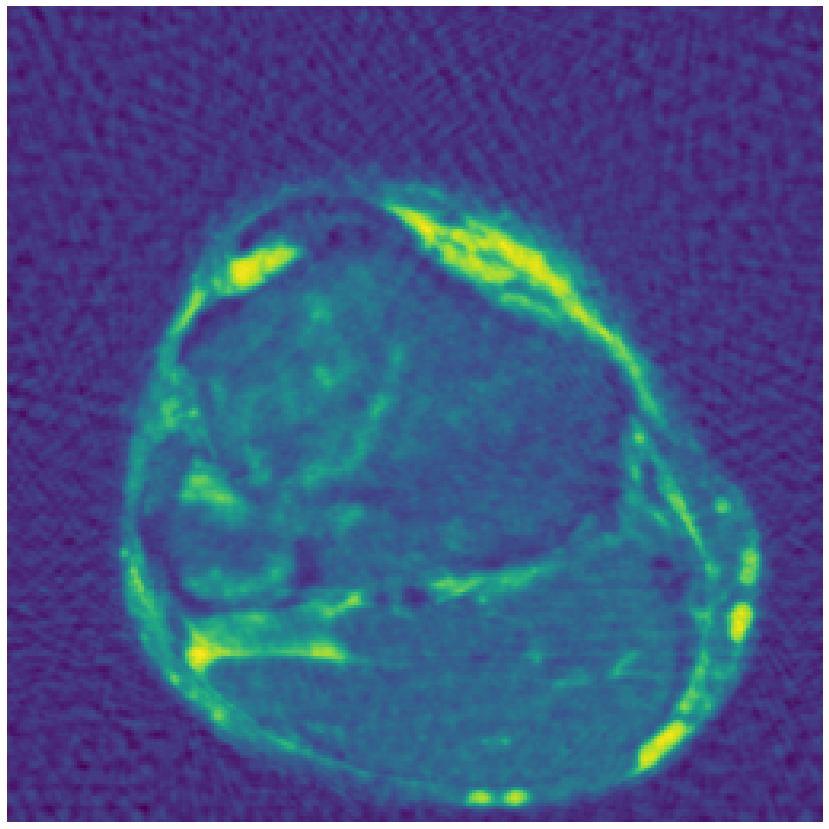

In [21]:
plt.figure(figsize=(15,15))
plt.imshow(operator.inverse_torch(m1).cpu()[3,0,...])
plt.axis('off')

In [54]:
size = 256
s = 1
c = 1
X, Y = np.meshgrid(np.arange(-size//2, size//2), np.arange(-size//2, size//2))
mask = (1 + c * (X ** 2 + Y ** 2)) ** (s / 2)

In [195]:
def l2(tensor):
    return np.sqrt(np.sum(tensor**2))

In [165]:
class Norm(object):
    def __init__(self, s, c=1, size=256):
        self.s = s
        self.c = c
        self.size = size
        X, Y = np.meshgrid(np.arange(-size//2, size//2), np.arange(-size//2, size//2))
        mask = np.reshape((1 + c * (X ** 2 + Y ** 2)) ** (s / 2), (1, 1, size, size, 1))
        self.tensor_mask = Variable(torch.Tensor(mask).cuda())
    
    @property
    def dual(self):
        return Norm(s=-self.s, c=self.c, size=self.size)
        
    def __call__(self, tensor):
        tensor = embed_tensor_complex(tensor)
        ft = fft2c(tensor)
        weighted = ft * self.tensor_mask
        return torch.mean(torch.sqrt(torch.sum(weighted ** 2, axis=(1, 2, 3, 4))))

In [192]:
W2 = Norm(s=1, c=1)

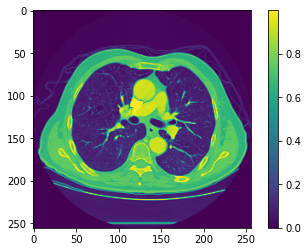

In [193]:
plt.imshow(sample[1,0,...])
plt.colorbar()

In [196]:
l2(ifft2c(W2(sample.cuda())))

TypeError: sum() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * (*, torch.dtype dtype)
      didn't match because some of the keywords were incorrect: out, axis
 * (tuple of names dim, bool keepdim, *, torch.dtype dtype)
 * (tuple of ints dim, bool keepdim, *, torch.dtype dtype)


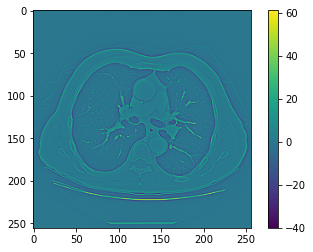

In [194]:
plt.imshow(ifft2c(W2(sample.cuda())).cpu()[1,0,...,0])
plt.colorbar()

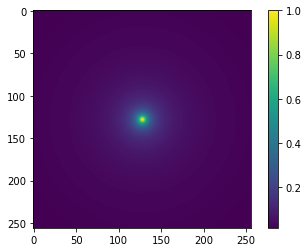

In [161]:
plt.imshow(W2.tensor_mask.cpu()[0,0,...,0])
plt.colorbar()

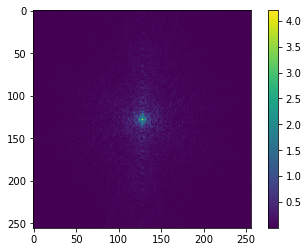

In [149]:
plt.imshow(np.log(np.abs(fft2c(tensor)[1,0,...,0])+1))
plt.colorbar()

In [158]:
plt.imshow(np.log(np.abs(weighted)[1,0,...,0])+1)
plt.colorbar()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

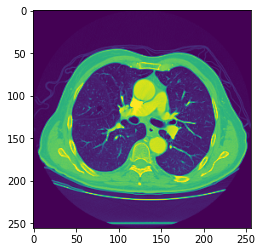

In [143]:
plt.imshow(ifft2c(ft)[1,0,...,0].cpu())

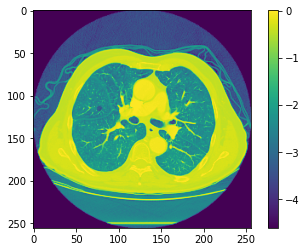

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [156]:
tensor = embed_tensor_complex(sample)
ft = fft2c(tensor)
plt.imshow(np.log(ifft2c(ft)[1,0,...,0].cpu() + 1e-2))
plt.colorbar()
plt.show()
weighted = ft * new_mask
plt.imshow(np.log(np.abs(ifft2c(weighted)[1,0,...,0].cpu())+1))
plt.colorbar()
plt.show()

In [55]:
mask = (1 + c * (X ** 2 + Y ** 2)) ** (s / 2)

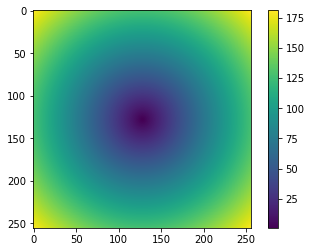

In [56]:
plt.imshow(mask)
plt.colorbar()

In [ ]:
def sobolev_filter(x, c=5, s=1):
    """Apply sobolev filter.
    Parameters
    ----------
    x : tensorflow.Tensor of shape B W H C
        txt
    c : float
        Scaling of the cooridinate systems (1 / pixel size)
    s : float
        Order of the Sobolev norm
    """
    # FFT is taken over the innermost axes, so move channel to beginning.
    x = tf.transpose(x, [0, 3, 1, 2])
    fft_x = tf.spectral.fft2d(tf.cast(x, 'complex64'))

    shape = tf.shape(fft_x)
    sx = shape[3]
    sy = shape[2]

    # Construct meshgrid for the scale
    x = np.range(sx)
    x = np.minimum(x, sx - x)
    x = tf.cast(x, dtype='complex64') / tf.cast(sx // 2, dtype='complex64')
    y = tf.range(sy)
    y = tf.minimum(y, sy - y)
    y = tf.cast(y, dtype='complex64') / tf.cast(sy // 2, dtype='complex64')
    X, Y = tf.meshgrid(x, y)
    X = X[None, None]
    Y = Y[None, None]

    scale = (1 + c * (X ** 2 + Y ** 2)) ** (s / 2)

    # Compute spatial gradient in fourier space
    fft_x = scale * fft_x

    result_x = tf.spectral.ifft2d(fft_x)
    result_x = tf.real(result_x)
    return tf.transpose(result_x, [0, 2, 3, 1])

In [ ]:
plt.imshow(module(sample)[1,0,...])

In [ ]:
measurements = add_noise(module(sample), .002)
plt.imshow(measurements[1,0,...])

In [ ]:
def add_noise(y, noise_level):
    noise = (Variable(y.new(y.shape).normal_(0, 1)))
    max_val = torch.abs(y).max()
    return y + noise_level*max_val*noise

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(sample[1,0,...])

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(fbp(module(sample))[1,0,...])

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(fbp(measurements)[1,0,...])

In [ ]:
plt.imshow(operator(sample[1,0,...]))

In [ ]:
(sample[1,0,...]).max()

In [ ]:
((operator(sample[1,0,...])).asarray()).max()

In [ ]:
for i, s in enumerate(dataset):
    print(s.shape)
    plt.imshow(s[0,0,...])
    plt.show()
    print('Min', s.min(), 'Max', s.max(), 'Mean', s.mean())
    if i>50:
        break

In [ ]:
plt.imshow(sample[0,0,...])

In [ ]:
sample.max()

In [ ]:
sample.min()

In [ ]:
dc.pixel_data_handlers.pillow_handler.is_available()

In [ ]:
from pydicom.uid import JPEG2000Lossless

In [ ]:
def find_paths(path, ending='dcm', p_max=5):
    # finds all files with defined pattern in path and all of its subfolders
    results = {}
    for root, dirs, files in os.walk(path):
        res = []
        for f in files:
            if f[-3:] == ending:
                res.append(f)
        if res:
            results[root] = res
        if p_max > 0:
            if len(results.keys()) > p_max:
                break
    return results

In [ ]:
path = '/store/CCIMI/sl767/LUNA/Evaluation_Data/'

In [ ]:
files = find_paths(path, ending='dcm', p_max = -1)

In [ ]:
len(files)

In [ ]:
with open(path+'summary.json', 'w') as fp:
    json.dump(files, fp)

In [ ]:
len(files.keys())
n_f = 0
for k, v in files.items():
    n_f += len(v)
print(n_f)

In [ ]:
# npys = []
# n_files = 0
# values = 0
# for k, v in files.items():
#     p = [os.path.join(k,i) for i in v]
#     n_files += len(p)
#     npys += p

In [ ]:
with open(path+'summary.json', 'r') as fp:
    files_loaded = json.load(fp)

In [ ]:
# with open(path+'individual_npy.json', 'r') as fp:
#     already_written = set(json.load(fp))

In [ ]:
n_dcms = 0
for k, v in files.items():
    n_dcms += len(v)
print(n_dcms)

In [ ]:
def save_as_np(path, saved_list, error_list):
    try:
        new_path = path[:-3]+'npy'
        if not os.path.exists(new_path):
            dc_file = dc.dcmread(path)
            pic = dc_file.pixel_array
            with open(new_path, 'wb') as f:
                np.save(f, pic)
        saved_list.append(new_path)
    except:
        error_list.append(path)

In [ ]:
saved_list = []
error_list = []
for k, v in tqdm(files.items(), total=len(files.keys())):
    for p in v:
        save_as_np(os.path.join(k, p), saved_list, error_list)
    with open(path+'individual_npy.json', 'w') as fp:
        json.dump(saved_list, fp)
    with open(path+'error_npy.json', 'w') as fp:
        json.dump(error_list, fp)

In [ ]:
saved_list

In [ ]:
p = '/store/CCIMI/sl767/fMRI/knee_mri_training/FB_271338____FB,2400281735/study_8b3598b1/MR4_89392568/00032_8910b534efc6f6d6.dcm'

In [ ]:
dc_file = dc.dcmread(p)
pic = dc_file.pixel_array
new_path = path[:-3]+'npy'
with open(new_path, 'wb') as f:
    np.save(f, pic)

In [23]:
from skimage.metrics import structural_similarity

In [ ]:
plt.imshow(dc_file.pixel_array)
plt.colorbar()

In [ ]:
'/store/CCIMI/sl767/fMRI/knee_mri_training/FB_271338____FB,2400281735/study_8b3598b1/MR4_89392568/00032_8910b534efc6f6d6.npy'[:-3]+ 'npy'

In [ ]:
with open('/store/CCIMI/sl767/fMRI/knee_mri_training/FB_271338____FB,2400281735/study_8b3598b1/MR4_89392568/00032_8910b534efc6f6d6.npy', 'wb') as f:
    np.save(f, dc_file.pixel_array)
    

In [ ]:
with open('/store/CCIMI/sl767/fMRI/knee_mri_training/FB_271338____FB,2400281735/study_8b3598b1/MR4_89392568/00032_8910b534efc6f6d6.npy', 'rb') as f:
    img_loaded = np.load(f)

In [ ]:
img_loaded

In [ ]:
plt.imshow(img_loaded)
plt.colorbar()

In [ ]:
os.listdir(path+'FB_986798____FB,7200391820/study_a24f4481/MR3_37825c3d')

In [ ]:
# load the DICOM files
files = []
print('glob: {}'.format(sys.argv[1]))
for fname in glob.glob(sys.argv[1], recursive=False):
    print("loading: {}".format(fname))
    files.append(pydicom.dcmread(fname))

print("file count: {}".format(len(files)))

# skip files with no SliceLocation (eg scout views)
slices = []
skipcount = 0
for f in files:
    if hasattr(f, 'SliceLocation'):
        slices.append(f)
    else:
        skipcount = skipcount + 1

print("skipped, no SliceLocation: {}".format(skipcount))

# ensure they are in the correct order
slices = sorted(slices, key=lambda s: s.SliceLocation)

# pixel aspects, assuming all slices are the same
ps = slices[0].PixelSpacing
ss = slices[0].SliceThickness
ax_aspect = ps[1]/ps[0]
sag_aspect = ps[1]/ss
cor_aspect = ss/ps[0]

# create 3D array
img_shape = list(slices[0].pixel_array.shape)
img_shape.append(len(slices))
img3d = np.zeros(img_shape)

# fill 3D array with the images from the files
for i, s in enumerate(slices):
    img2d = s.pixel_array
    img3d[:, :, i] = img2d

In [ ]:
torch.cuda.device_count()

In [ ]:
data = LUNA('/store/CIA/sl767/LUNA/')

In [ ]:
image = data.load_data(training_data=False)
image = np.expand_dims(image, axis=0)

In [ ]:
plt.imshow(image[0,...,0])

In [ ]:
size = 128
angles = 120
# max_ang=2*np.pi/3
# max_ang= np.pi
detectors = 128

space = odl.uniform_discr([-size//2, -size//2], [size//2, size//2], [size, size], dtype='float32')
if angles != 0:
#     angle_partition = odl.uniform_partition(0, max_ang, angles)
#     detector_partition = odl.uniform_partition(-362.0, 362.0, detectors)
#     geometry = odl.tomo.Parallel2dGeometry(angle_partition, detector_partition)
    geometry = odl.tomo.parallel_beam_geometry(space, num_angles=angles, det_shape=(detectors,))
    fwd_op = odl.tomo.RayTransform(space, geometry, impl='astra_cuda')


#     fbp_op = odl.tomo.fbp_op(fwd_op)#,filter_type='Hann')
#     fwd_op_mod=OperatorModule(fwd_op)
#     fwd_op_adj_mod=OperatorModule(fwd_op.adjoint)

#     rec_size = fwd_op.range.shape[1]
#     fbp_op_mod = OperatorModule(fbp_op)

In [ ]:
ip = space.element(image[0, ..., 0])
result = fwd_op(ip)

In [ ]:
plt.imshow(result)

In [ ]:
inverse = odl.tomo.fbp_op(fwd_op)

In [ ]:
recon = inverse(result)
plt.imshow(recon)
plt.colorbar()

In [ ]:
plt.imshow(np.array(recon) - image[0,...,0])
plt.colorbar()

In [ ]:
adj = fwd_op.adjoint

In [ ]:
plt.imshow(adj(result))

In [ ]:
inp_image = tf.placeholder(shape=(1,128,128,1), dtype = tf.complex64, name='Image')
output = tf.fftshift(tf.fft2d(inp_image, name='FT'))

In [ ]:
fft = sess.run(output, feed_dict={inp_image:image})

In [ ]:
import skimage

In [ ]:
fft.dtype

In [ ]:
plt.imshow(np.real(np.fft.fftshift(fft[0,...,0], axes=None)))
plt.colorbar()

In [ ]:
plt.imshow(np.imag(np.fft.fftshift(fft[0,...,0])))
plt.colorbar()

In [ ]:
plt.imshow(np.real(np.fft.fftshift(np.fft.fft2(image[0,...,0]))))
plt.colorbar()